In [1]:
import glob
import numpy as np 
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from colav.extract_data_matrix import * 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

In [2]:
# untreated dihedral data processing
theseus_strucs = sorted(glob.glob('../data/theseus_data/*pdb'))
untreated_dihedrals, dihedral_strucs = generate_dihedral_matrix(theseus_strucs, 
                                                                (7,279), 
                                                                verbose=False)
untreated_dihedrals_data = np.hstack([np.sin(untreated_dihedrals),
                                      np.cos(untreated_dihedrals)])

In [3]:
# rope dihedral data processing 
rope_dihedrals = pd.read_csv('../data/filtered-ptp1b.csv')
rope_strucs = np.array([x[:-2] for x in rope_dihedrals.Name.values])
rope_dihedrals.drop(['Unnamed: 0', 'Name'], axis=1, inplace=True)
rope_dihedrals = np.deg2rad(rope_dihedrals.values)
rope_dihedrals_data = np.hstack([np.sin(rope_dihedrals),
                                 np.cos(rope_dihedrals)])

In [4]:
# Dihedral PCA 
# untreated 
u_pca = PCA(n_components=10)
u_A = u_pca.fit_transform(untreated_dihedrals_data)

# rope
rope_pca = PCA(n_components=10)
rope_A = rope_pca.fit_transform(rope_dihedrals_data)

In [5]:
# pairwise distances data processing
pw_data, pw_strucs = generate_pw_matrix(theseus_strucs, 
                                        (7,279))

In [6]:
# Pairwise Distance PCA 
pw_pca = PCA(n_components=10)
pw_A = pw_pca.fit_transform(pw_data)

In [7]:
# strain data processing
sa_data, sa_strucs = generate_strain_matrix(theseus_strucs, 
                                            '../data/theseus_data/theseus_1sug_chainA.pdb', 
                                            'sheart', 
                                            (7,279))

In [8]:
# Strain Analysis PCA 
sa_pca = PCA(n_components=10)
sa_A = sa_pca.fit_transform(sa_data)

In [9]:
conformation_dict = pickle.load(open('conformation_dict.pkl', 'rb'))

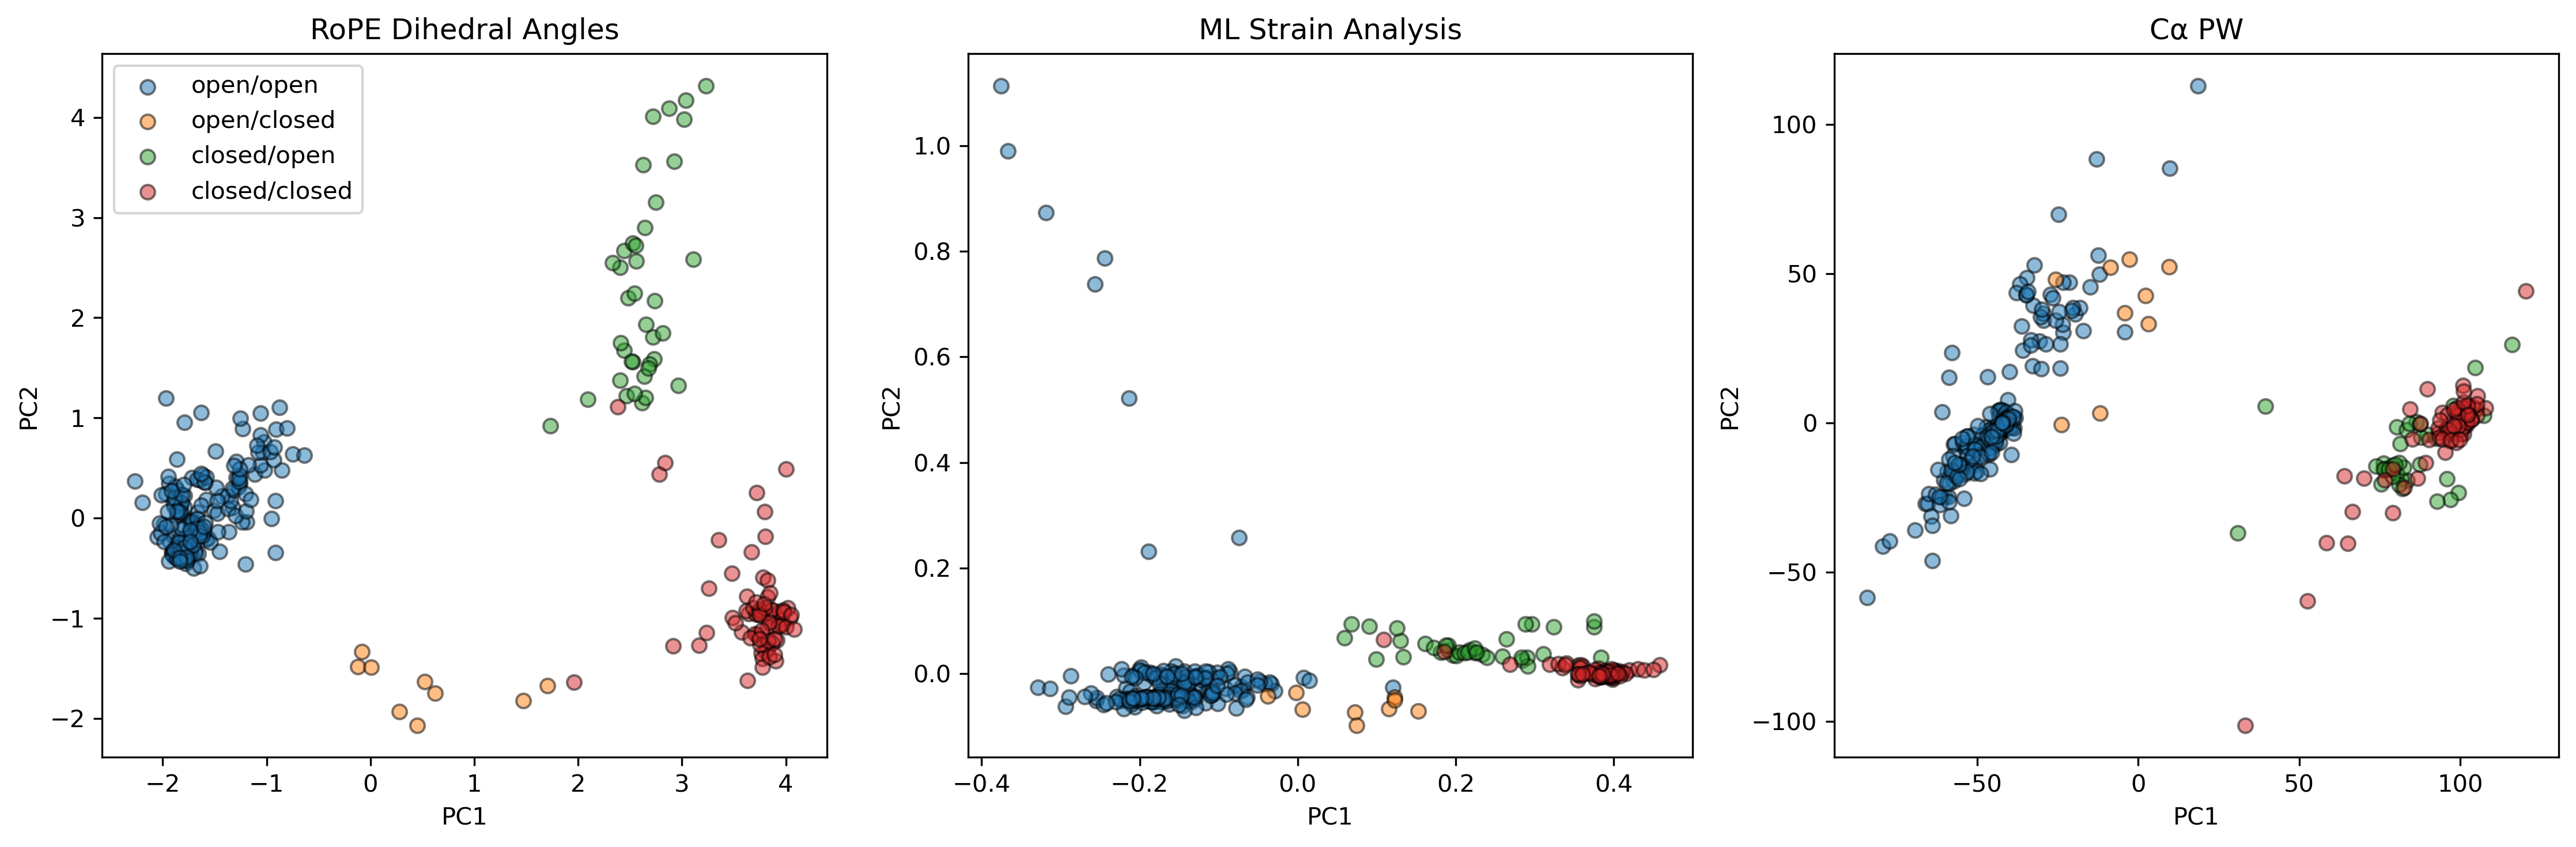

In [10]:
# PC space plots 
fig, ax = plt.subplots(1, 3, figsize=(15,5), dpi=300); ax = ax.flatten()
pca_list = [rope_A, sa_A, pw_A]
struc_list_list = [
    rope_strucs,  
    sa_strucs, 
    pw_strucs
]
title_list = [
    "RoPE Dihedral Angles", 
    "ML Strain Analysis", 
    u"C\u03b1 PW"
]

# enumerate the axes and the list of the PCAs
for i in np.arange(len(pca_list)): 

    # determine conformation color
    conformations = list()
    for k in struc_list_list[i]: 
        if k.startswith('../data'): 
            conformations.append(conformation_dict[k.split('/')[-1][8:-4]])
        else: 
            conformations.append(conformation_dict[k])

    conformations = np.array(conformations)
    cluster1 = ax[i].scatter(pca_list[i][conformations == "open_open",0], pca_list[i][conformations == "open_open",1], marker='o', alpha=0.5, edgecolor='k', linewidth=1, label="open/open")
    cluster2 = ax[i].scatter(pca_list[i][conformations == "open_closed",0], pca_list[i][conformations == "open_closed",1], marker='o', alpha=0.5, edgecolor='k', linewidth=1, label="open/closed")
    cluster3 = ax[i].scatter(pca_list[i][conformations == "closed_open",0], pca_list[i][conformations == "closed_open",1], marker='o', alpha=0.5, edgecolor='k', linewidth=1, label="closed/open")
    cluster4 = ax[i].scatter(pca_list[i][conformations == "closed_closed",0], pca_list[i][conformations == "closed_closed",1], marker='o', alpha=0.5, edgecolor='k', linewidth=1, label="closed/closed")
    ax[i].set_ylabel("PC2")
    ax[i].set_xlabel("PC1")
    ax[i].set_title(title_list[i])
ax[0].legend(loc="upper left", handles=[cluster1, cluster2, cluster3, cluster4], labels=["open/open", "open/closed", "closed/open", "closed/closed"])
plt.tight_layout()
plt.show()

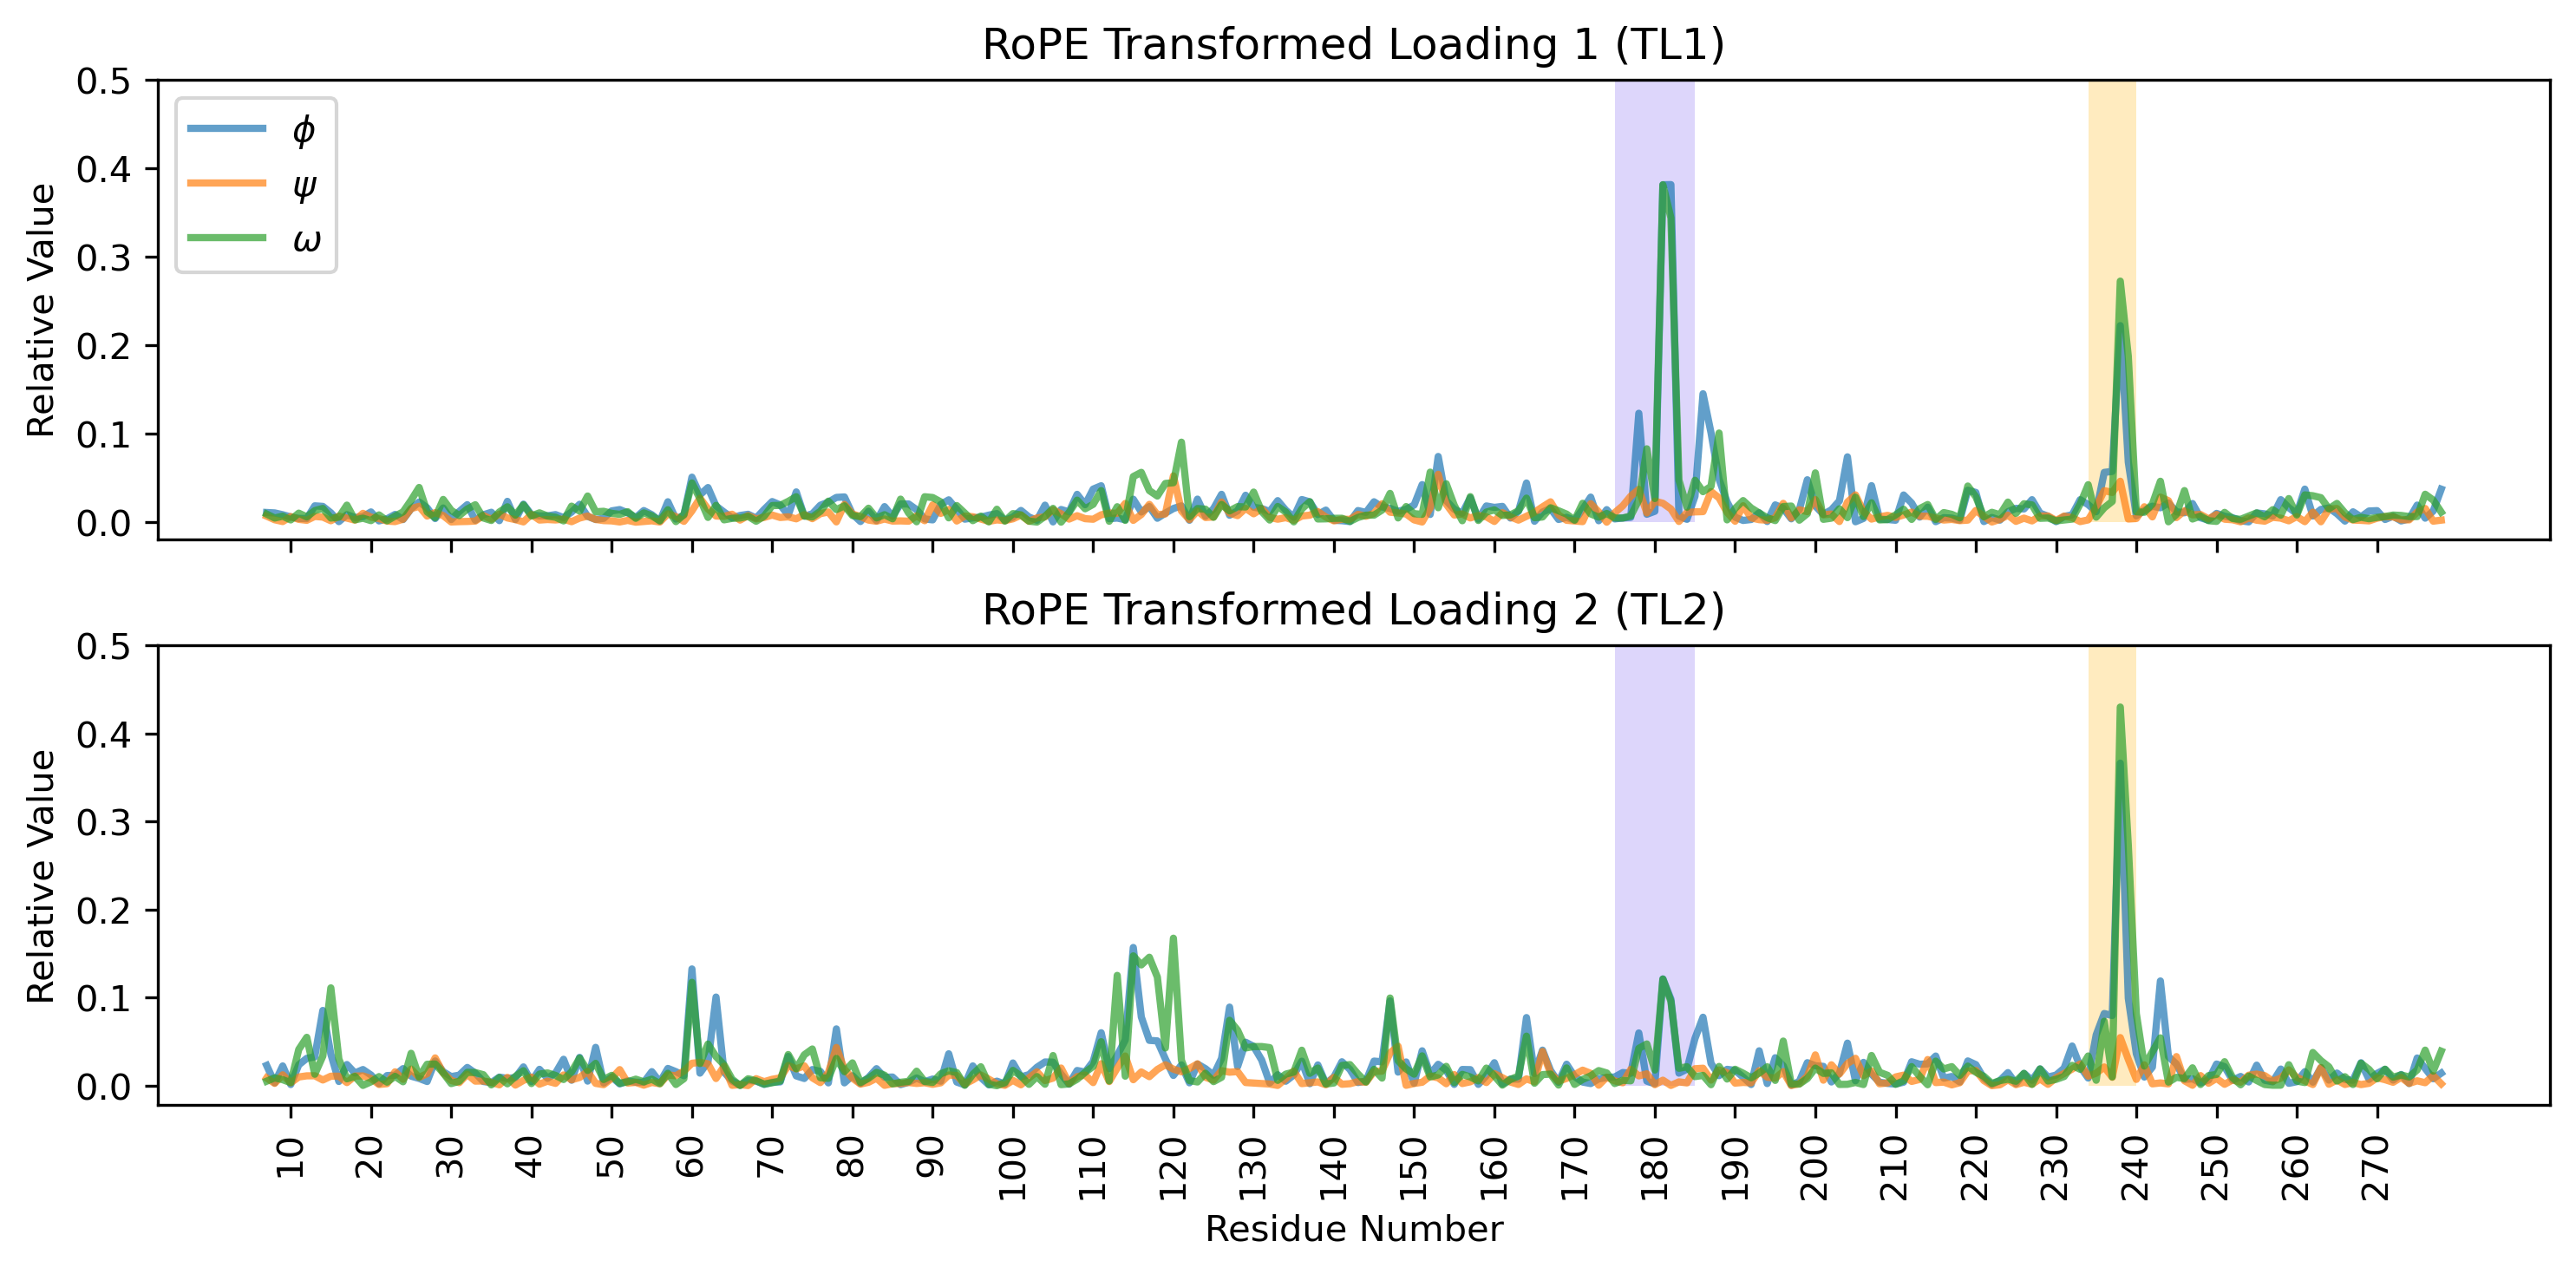

In [11]:
# rope treated dihedrals
r = 2
resnum_bounds = (7,279)
fig, ax = plt.subplots(r,1,figsize=(10,5), dpi=300); ax = ax.flatten()
psi_idx = np.arange(0,rope_dihedrals_data.shape[1]//2,3)
omg_idx = np.arange(1,rope_dihedrals_data.shape[1]//2,3)
phi_idx = np.arange(2,rope_dihedrals_data.shape[1]//2,3)
dh_range = np.arange(resnum_bounds[0], resnum_bounds[1])
for k in np.arange(r): 

    phi_trace, = ax[k].plot(dh_range, calculate_dihedral_transformed_loading(rope_pca.components_[k])[phi_idx], '-', label=r'$\phi$', linewidth=2, alpha=0.7)
    psi_trace, = ax[k].plot(dh_range, calculate_dihedral_transformed_loading(rope_pca.components_[k])[psi_idx], '-', label=r'$\psi$', linewidth=2, alpha=0.7)
    omg_trace, = ax[k].plot(dh_range, calculate_dihedral_transformed_loading(rope_pca.components_[k])[omg_idx], '-', label=r'$\omega$', linewidth=2, alpha=0.7)

    ax[k].set_title(f'RoPE Transformed Loading {k+1} (TL{k+1})')
    ax[k].set_xticks([dh for dh in dh_range if dh%10 == 0], labels=[dh for dh in dh_range if dh%10 == 0], rotation="vertical")
    ax[k].set_yticks(np.arange(0, ax[k].get_yticks().max(), 0.1), labels=np.round(np.arange(0, ax[k].get_yticks().max(), 0.1), 2))

    ax[k].add_patch(Rectangle((175,0), width=10, height=3.5, # WPD loop 
                facecolor="#785EF0", 
                alpha=0.25,
                fill=True))
    ax[k].add_patch(Rectangle((234,0), width=6, height=3.5, # L16 loop
                facecolor="#FFB000", 
                alpha=0.25,
                fill=True))

    # if k == 0: 
    #     ax[k].legend([phi_trace, omg_trace, psi_trace], [r"$\phi$", r"$\omega$", r"$\psi$"], fontsize=20, loc="upper left")
    ax[k].set_ylabel('Relative Value')
ax[0].set_xticklabels([])
ax[0].legend(loc="upper left")
ax[-1].set_xlabel("Residue Number")
plt.tight_layout()
plt.show()

In [12]:
fragment_strucs = list()
fragment_dihedrals_data = list()
for i,k in enumerate(rope_strucs): 
    if "PTP1B-y" in k: 
        fragment_strucs.append(k)
        fragment_dihedrals_data.append(rope_dihedrals_data[i,:])
fragment_dihedrals_data = np.array(fragment_dihedrals_data)

fragment_pca = PCA(n_components=10)
fragment_A = fragment_pca.fit_transform(fragment_dihedrals_data)

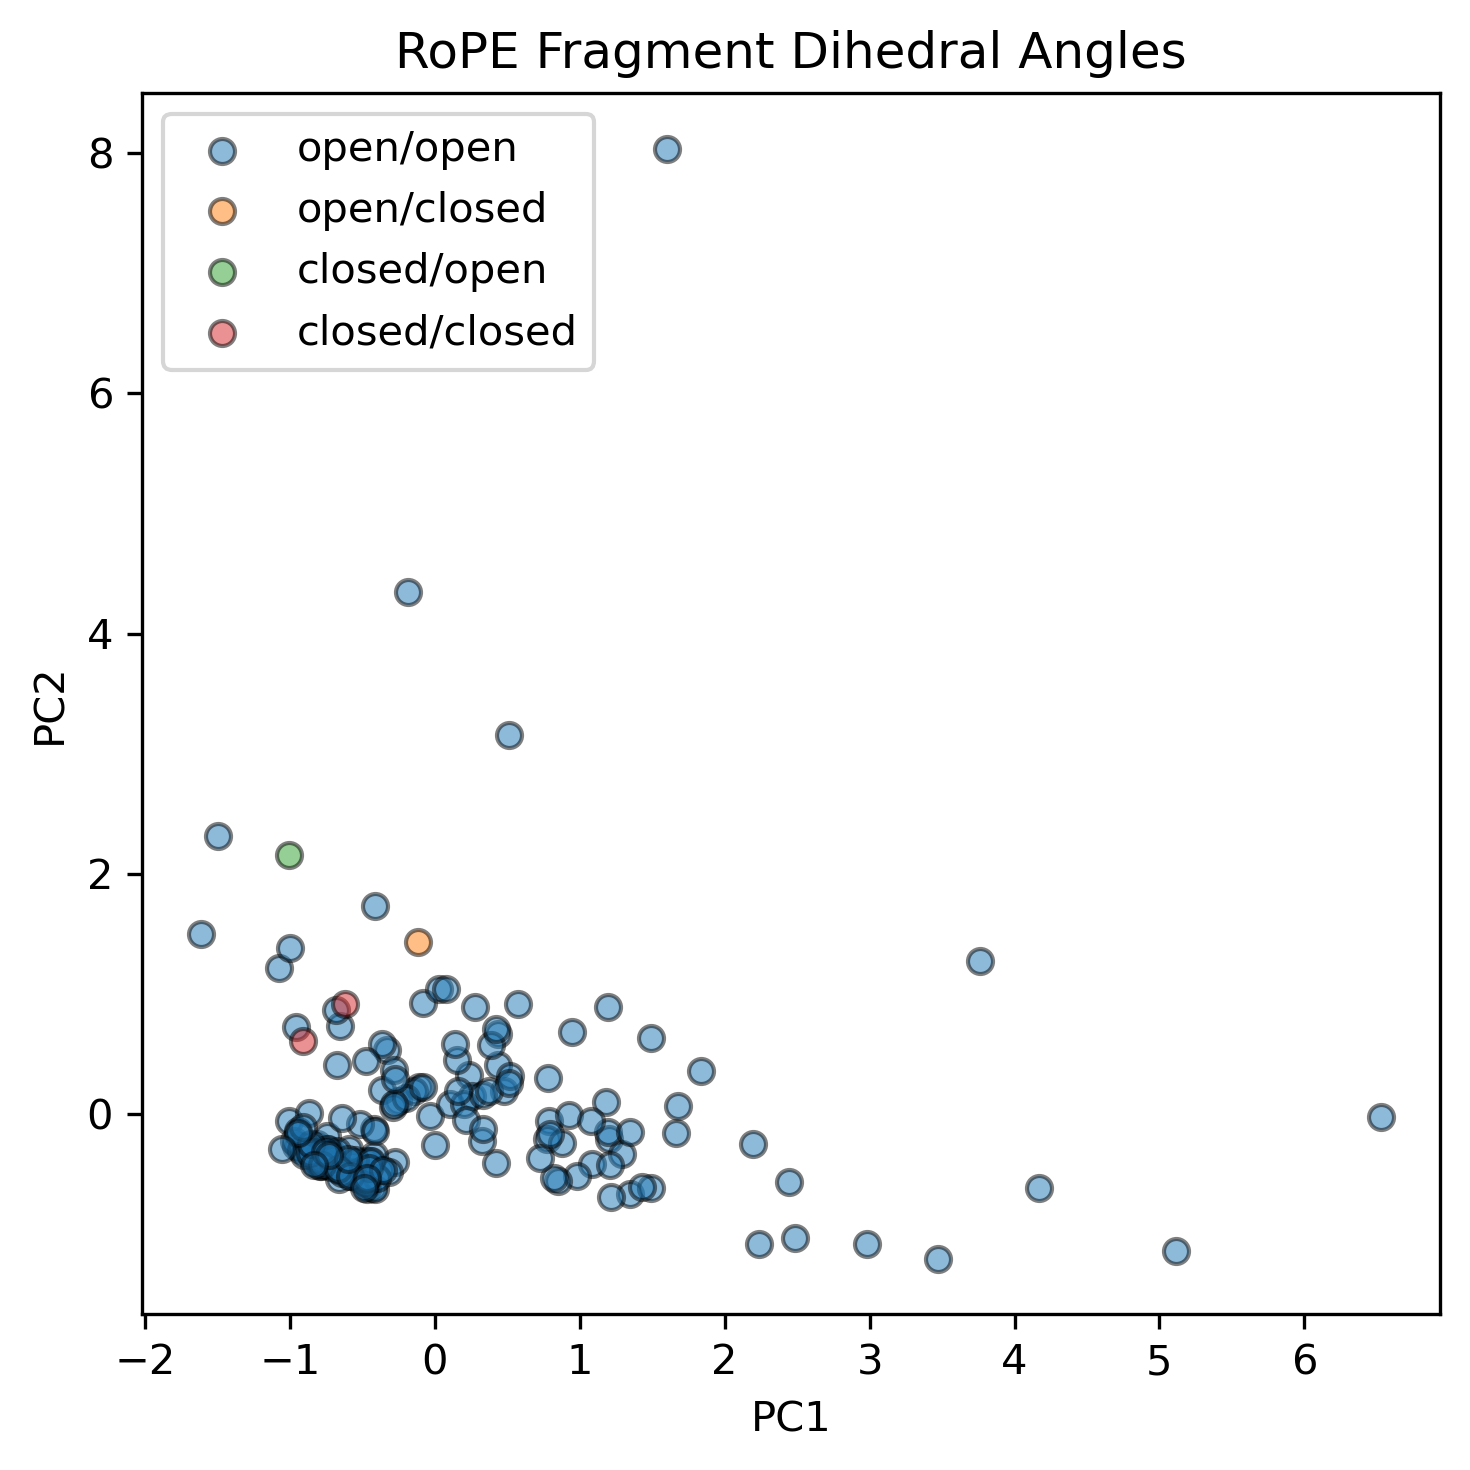

In [13]:
# PC space plots 
fig, ax = plt.subplots(1, 1, figsize=(5,5),dpi=300)
pca_list = [fragment_A]
struc_list_list = [
    fragment_strucs
]
title_list = [
    "RoPE Fragment Dihedral Angles"
]

# enumerate the axes and the list of the PCAs
for i in np.arange(len(pca_list)): 

    # determine conformation color
    conformations = list()
    for k in struc_list_list[i]: 
        if k.startswith('../data'): 
            conformations.append(conformation_dict[k.split('/')[-1][8:-4]])
        else: 
            conformations.append(conformation_dict[k])

    conformations = np.array(conformations)
    cluster1 = ax.scatter(pca_list[i][conformations == "open_open",0], pca_list[i][conformations == "open_open",1], marker='o', alpha=0.5, edgecolor='k', linewidth=1, label="open/open")
    cluster2 = ax.scatter(pca_list[i][conformations == "open_closed",0], pca_list[i][conformations == "open_closed",1], marker='o', alpha=0.5, edgecolor='k', linewidth=1, label="open/closed")
    cluster3 = ax.scatter(pca_list[i][conformations == "closed_open",0], pca_list[i][conformations == "closed_open",1], marker='o', alpha=0.5, edgecolor='k', linewidth=1, label="closed/open")
    cluster4 = ax.scatter(pca_list[i][conformations == "closed_closed",0], pca_list[i][conformations == "closed_closed",1], marker='o', alpha=0.5, edgecolor='k', linewidth=1, label="closed/closed")
    ax.set_ylabel("PC2")
    ax.set_xlabel("PC1")
    ax.set_title(title_list[i])
ax.legend(loc="upper left", handles=[cluster1, cluster2, cluster3, cluster4], labels=["open/open", "open/closed", "closed/open", "closed/closed"])
plt.tight_layout()
plt.show()

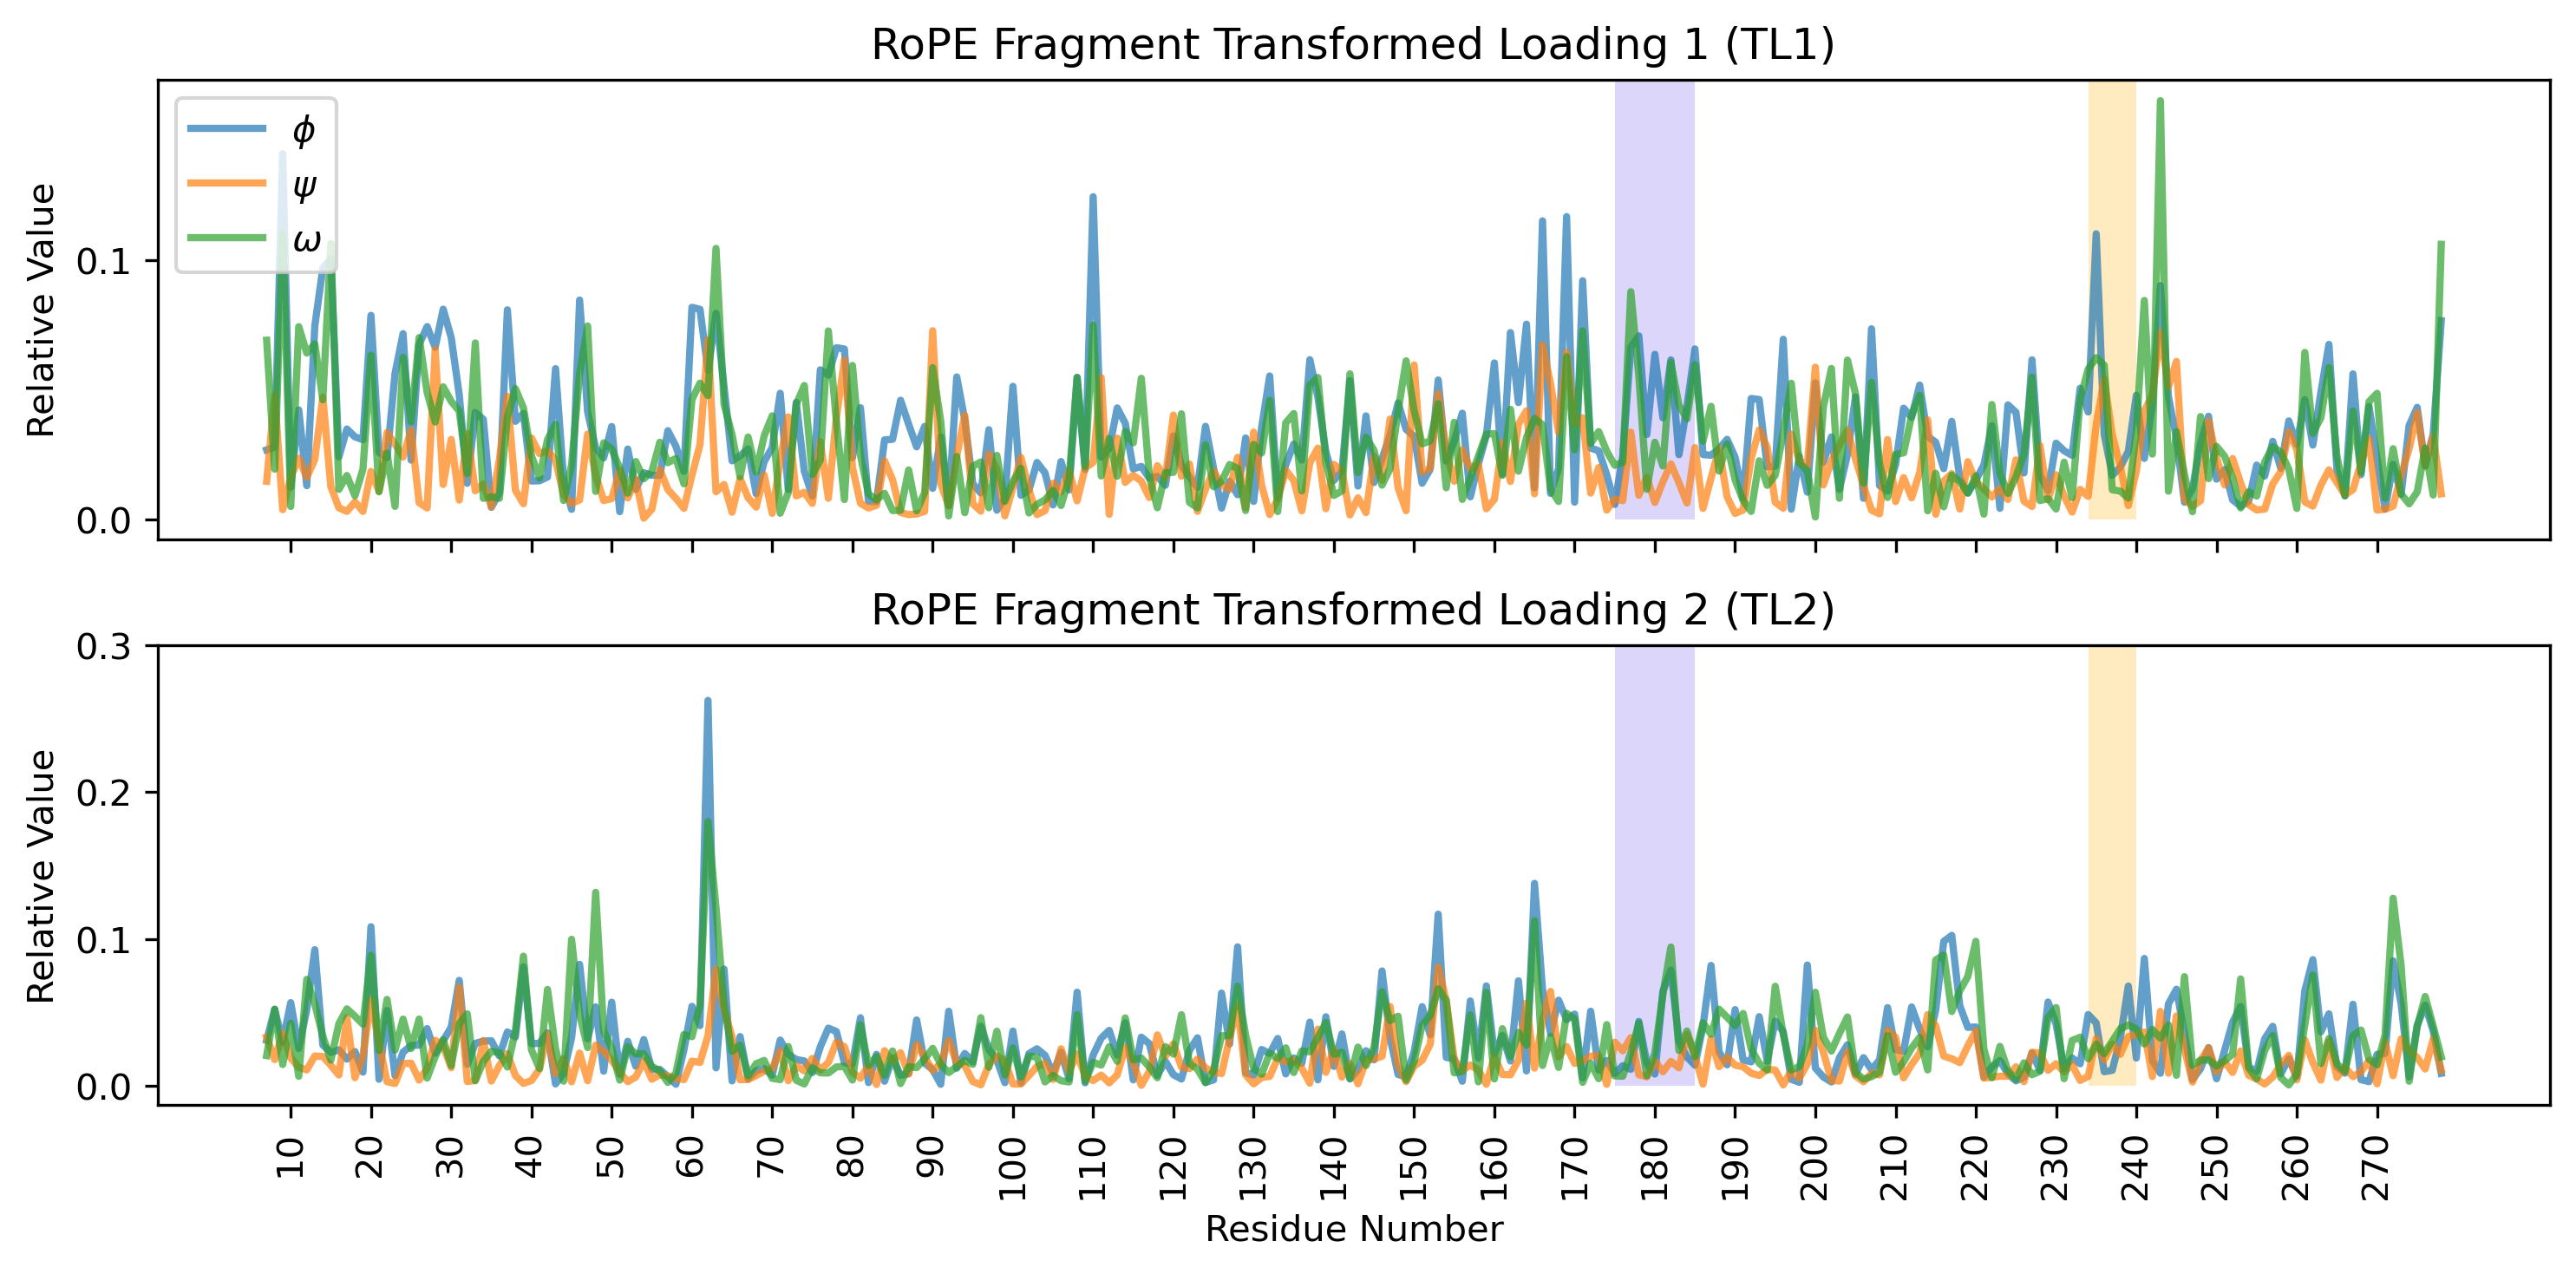

In [14]:
# rope fragment treated dihedrals
r = 2
fig, ax = plt.subplots(r,1,figsize=(10,5),dpi=300); ax = ax.flatten()
psi_idx = np.arange(0,fragment_dihedrals_data.shape[1]//2,3)
omg_idx = np.arange(1,fragment_dihedrals_data.shape[1]//2,3)
phi_idx = np.arange(2,fragment_dihedrals_data.shape[1]//2,3)
dh_range = np.arange(resnum_bounds[0], resnum_bounds[1])
for k in np.arange(r): 

    phi_trace, = ax[k].plot(dh_range, calculate_dihedral_transformed_loading(fragment_pca.components_[k])[phi_idx], '-', label=r'$\phi$', linewidth=2, alpha=0.7)
    psi_trace, = ax[k].plot(dh_range, calculate_dihedral_transformed_loading(fragment_pca.components_[k])[psi_idx], '-', label=r'$\psi$', linewidth=2, alpha=0.7)
    omg_trace, = ax[k].plot(dh_range, calculate_dihedral_transformed_loading(fragment_pca.components_[k])[omg_idx], '-', label=r'$\omega$', linewidth=2, alpha=0.7)

    ax[k].set_title(f'RoPE Fragment Transformed Loading {k+1} (TL{k+1})')
    ax[k].set_xticks([dh for dh in dh_range if dh%10 == 0], labels=[dh for dh in dh_range if dh%10 == 0], rotation="vertical")
    ax[k].set_yticks(np.arange(0, ax[k].get_yticks().max(), 0.1), labels=np.round(np.arange(0, ax[k].get_yticks().max(), 0.1), 2))

    ax[k].add_patch(Rectangle((175,0), width=10, height=3.5, # WPD loop 
                facecolor="#785EF0", 
                alpha=0.25,
                fill=True))
    ax[k].add_patch(Rectangle((234,0), width=6, height=3.5, # L16 loop
                facecolor="#FFB000", 
                alpha=0.25,
                fill=True))

    # if k == 0: 
    #     ax[k].legend([phi_trace, omg_trace, psi_trace], [r"$\phi$", r"$\omega$", r"$\psi$"], fontsize=20, loc="upper left")
    ax[k].set_ylabel('Relative Value')
ax[0].set_xticklabels([])
ax[0].legend(loc="upper left")
ax[-1].set_xlabel("Residue Number")
plt.tight_layout()
plt.show()

In [15]:
space_group_dict = pickle.load(open('space_group_dict.pkl', 'rb'))

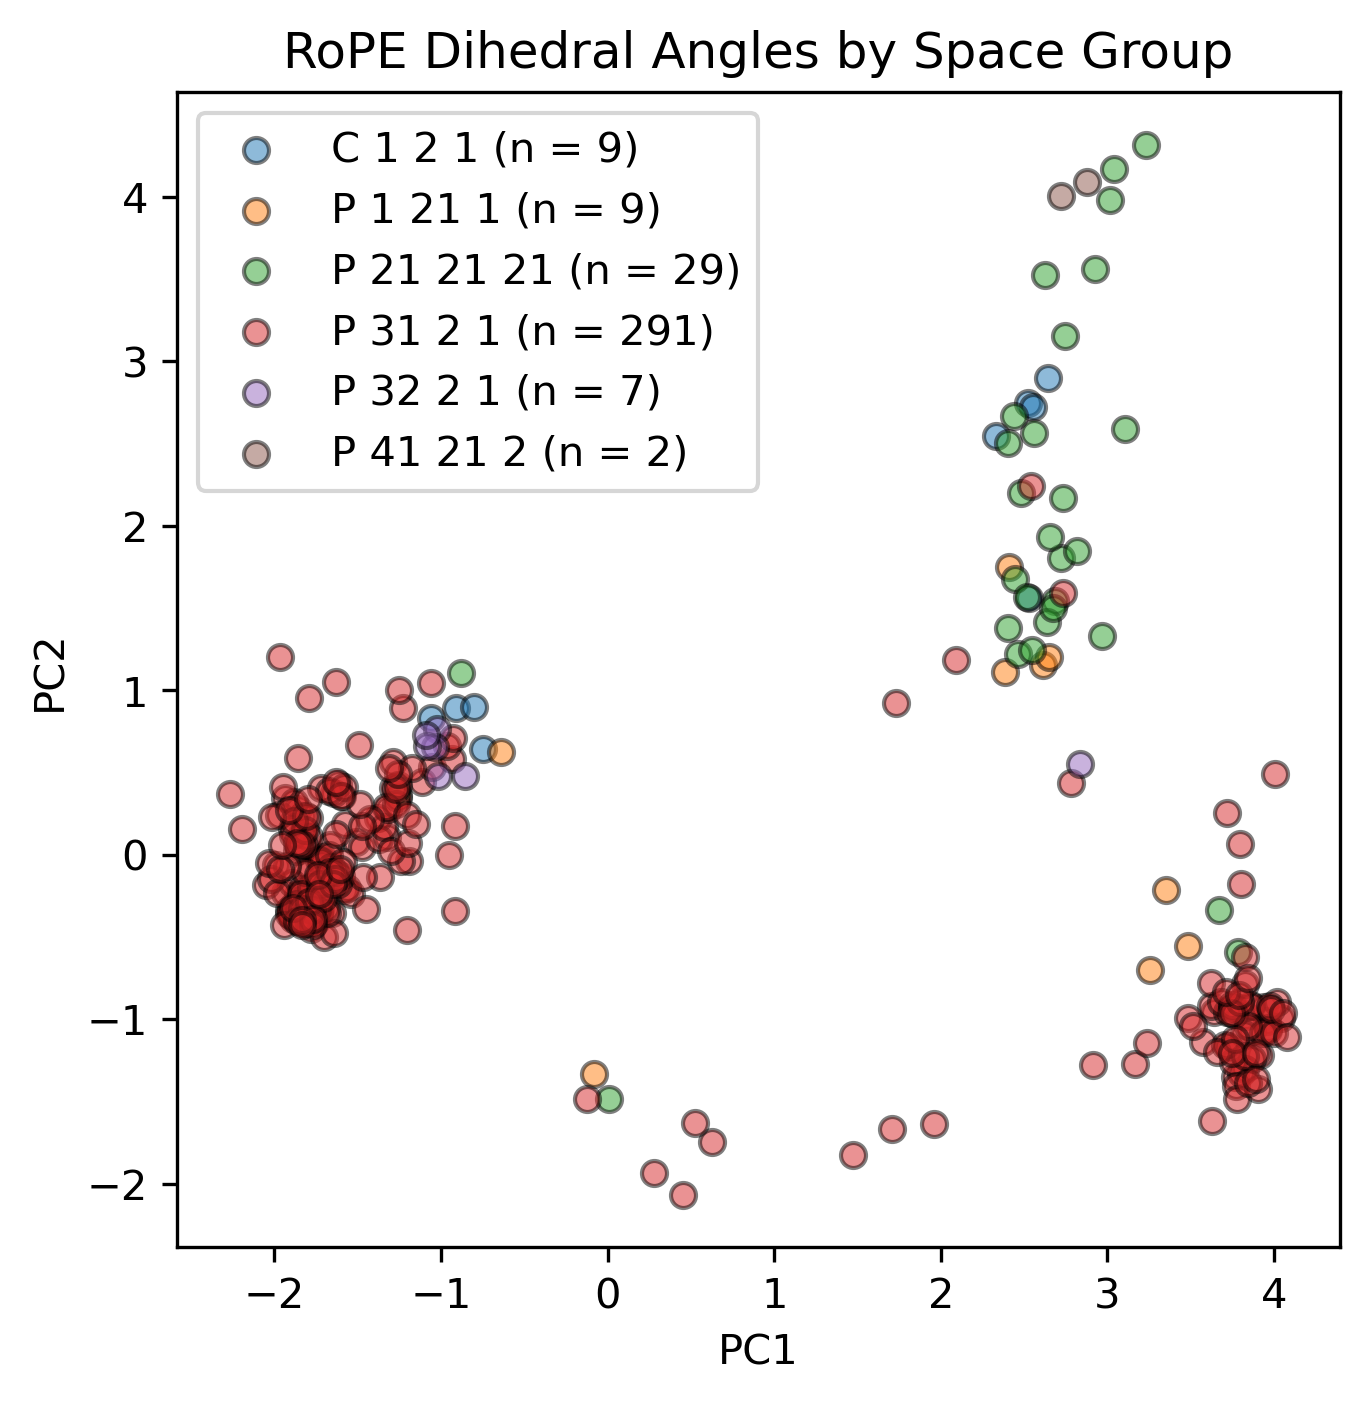

In [16]:
# determine the space groups of each of the structures 
sgs = list()
for i,struc in enumerate(rope_strucs): 
    
    sgs.append(space_group_dict[struc.split('_')[0]])
sgs = np.array(sgs)

# PC plot by space group
fig, ax = plt.subplots(1, 1, figsize=(5,5),dpi=300)
for i,sg in enumerate(np.unique(sgs)): 
    
    
    ax.scatter(rope_A[sgs == sg,0], rope_A[sgs == sg,1], marker='o', edgecolor='k', label=f"{sg} (n = {(sgs== sg).sum()})", alpha=0.5)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("RoPE Dihedral Angles by Space Group")
ax.legend()
plt.show()

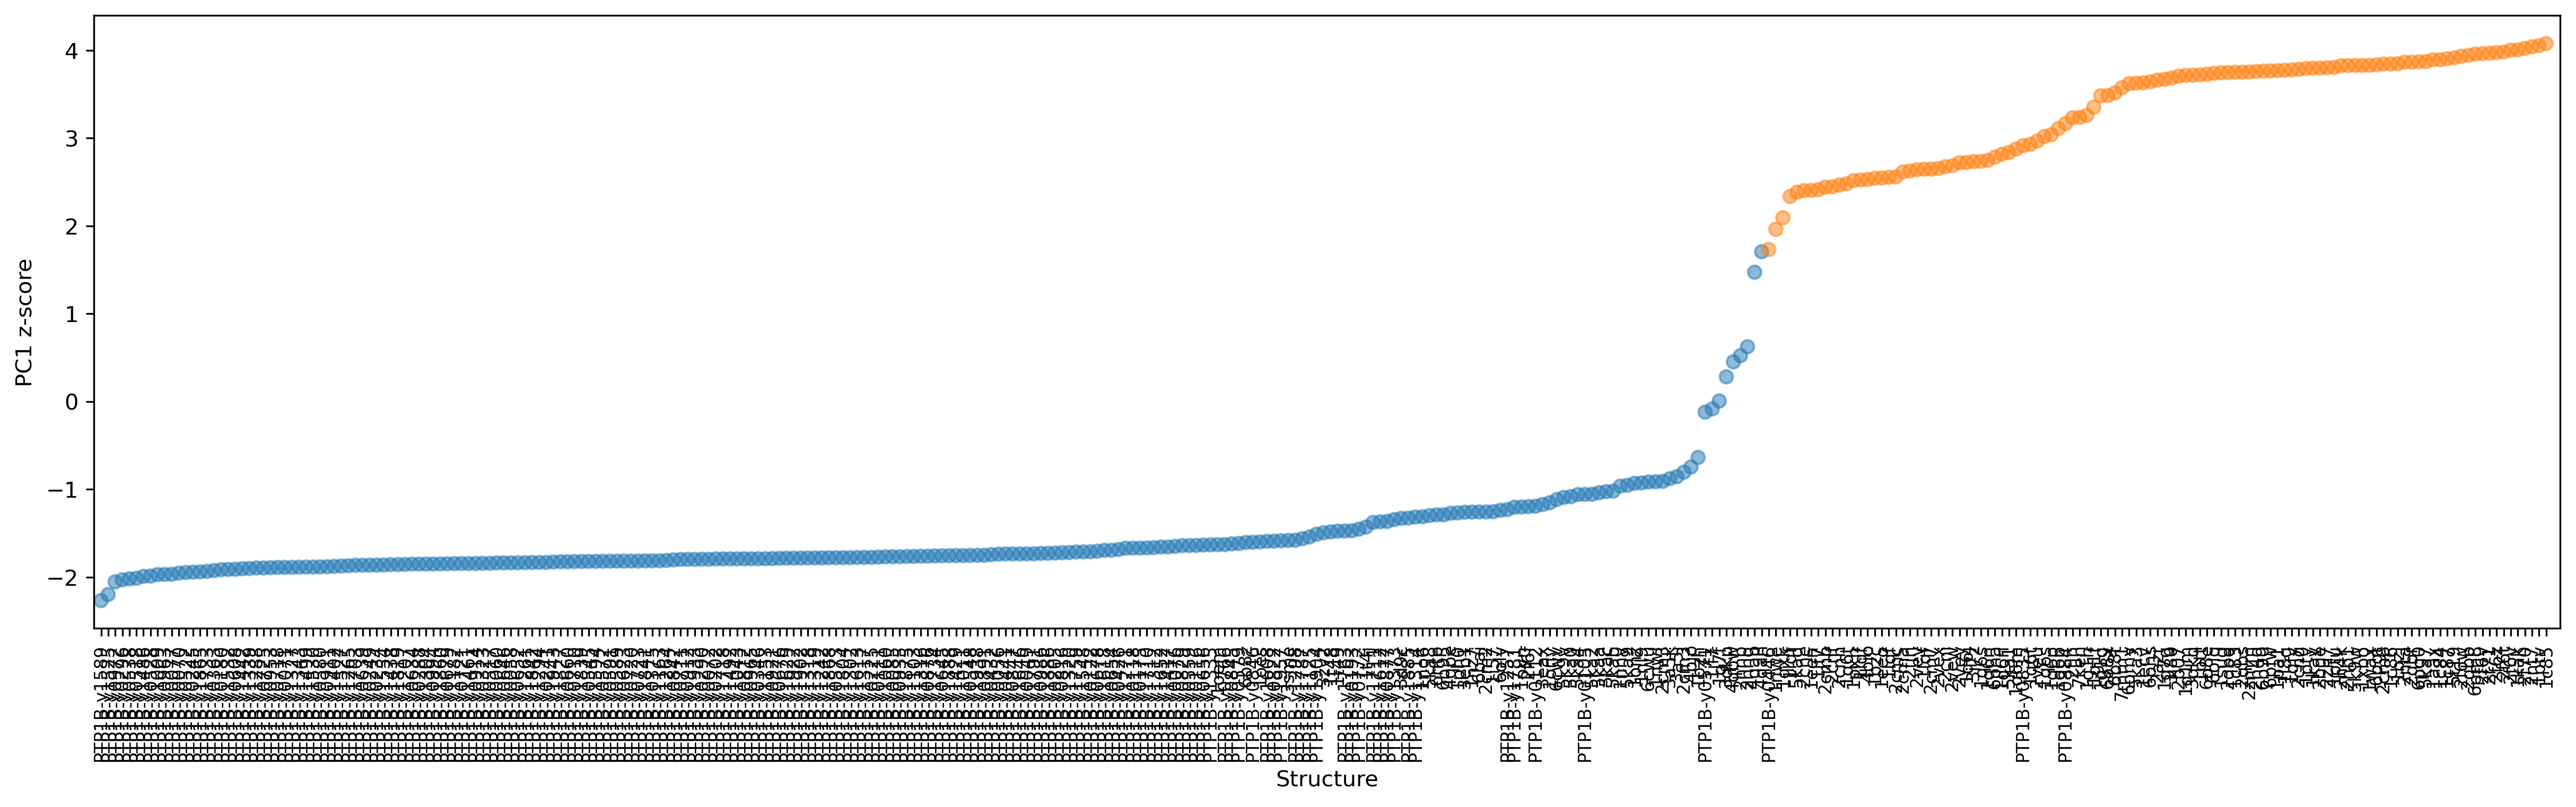

In [17]:
# allosteric steering for rope dihedrals pc 1 
fig, ax = plt.subplots(figsize=(20,5), dpi=300)

pc1_idxs = np.argsort(rope_A[:,0])
wpd_conformation = list()
for i,struc in enumerate(rope_strucs[pc1_idxs]): 
    wpd_conformation.append(conformation_dict[struc].split('_')[0])
wpd_conformation = np.array(wpd_conformation)
ax.scatter(np.arange(rope_A.shape[0]), rope_A[pc1_idxs,0], alpha=0.5, c=['tab:blue' if x == 'open' else 'tab:orange' for x in wpd_conformation])
ax.set_xlabel('Structure')
ax.set_ylabel('PC1 z-score')
ax.set_xlim(left=-1, right=rope_A.shape[0]+1)
ax.set_xticks(np.arange(rope_A.shape[0]))
ax.set_xticklabels([x[:-7] for x in rope_strucs[pc1_idxs]], rotation='vertical', fontsize=8)
plt.show()

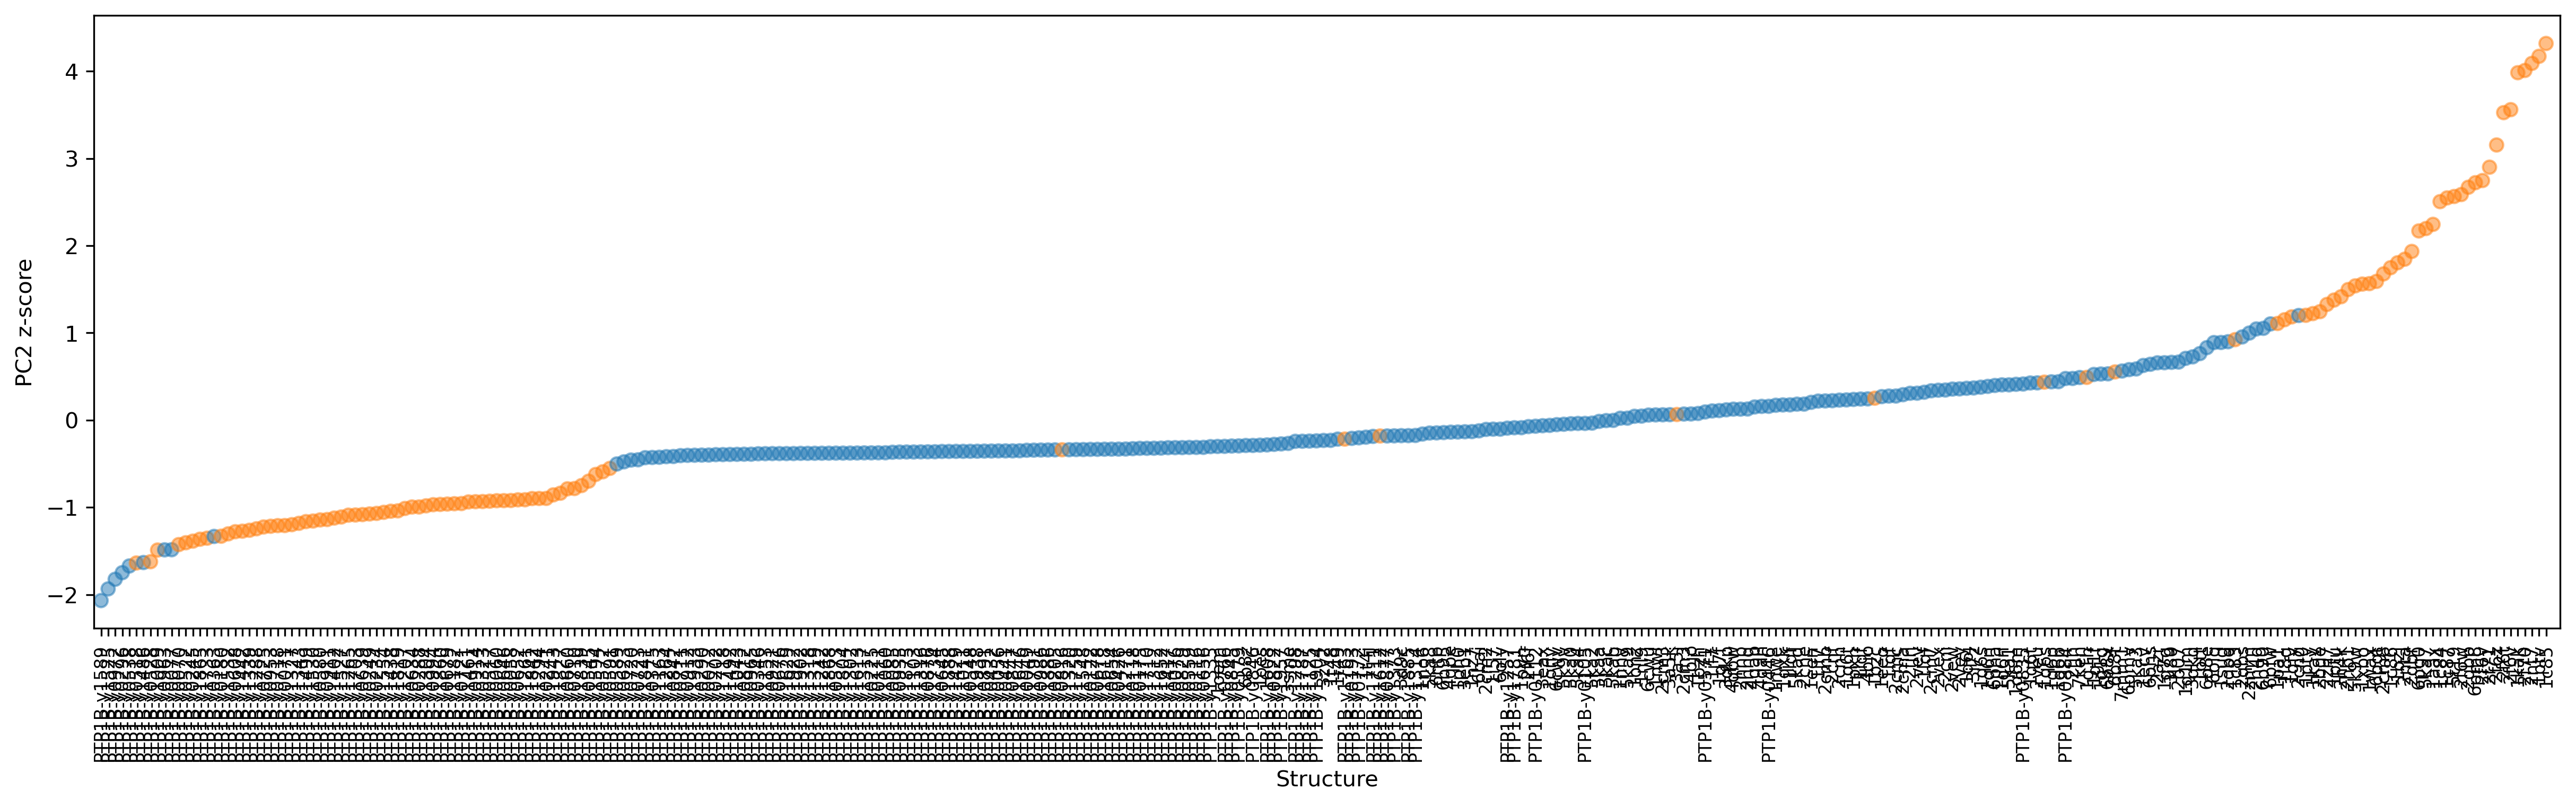

In [18]:
# allosteric steering for rope dihedrals pc 2
fig, ax = plt.subplots(figsize=(20,5), dpi=300)

pc2_idxs = np.argsort(rope_A[:,1])
wpd_conformation = list()
for i,struc in enumerate(rope_strucs[pc2_idxs]): 
    wpd_conformation.append(conformation_dict[struc].split('_')[0])
wpd_conformation = np.array(wpd_conformation)
ax.scatter(np.arange(rope_A.shape[0]), rope_A[pc2_idxs,1], alpha=0.5, c=['tab:blue' if x == 'open' else 'tab:orange' for x in wpd_conformation])
ax.set_xlabel('Structure')
ax.set_ylabel('PC2 z-score')
ax.set_xlim(left=-1, right=rope_A.shape[0]+1)
ax.set_xticks(np.arange(rope_A.shape[0]))
ax.set_xticklabels([x[:-7] for x in rope_strucs[pc1_idxs]], rotation='vertical', fontsize=8)
plt.show()

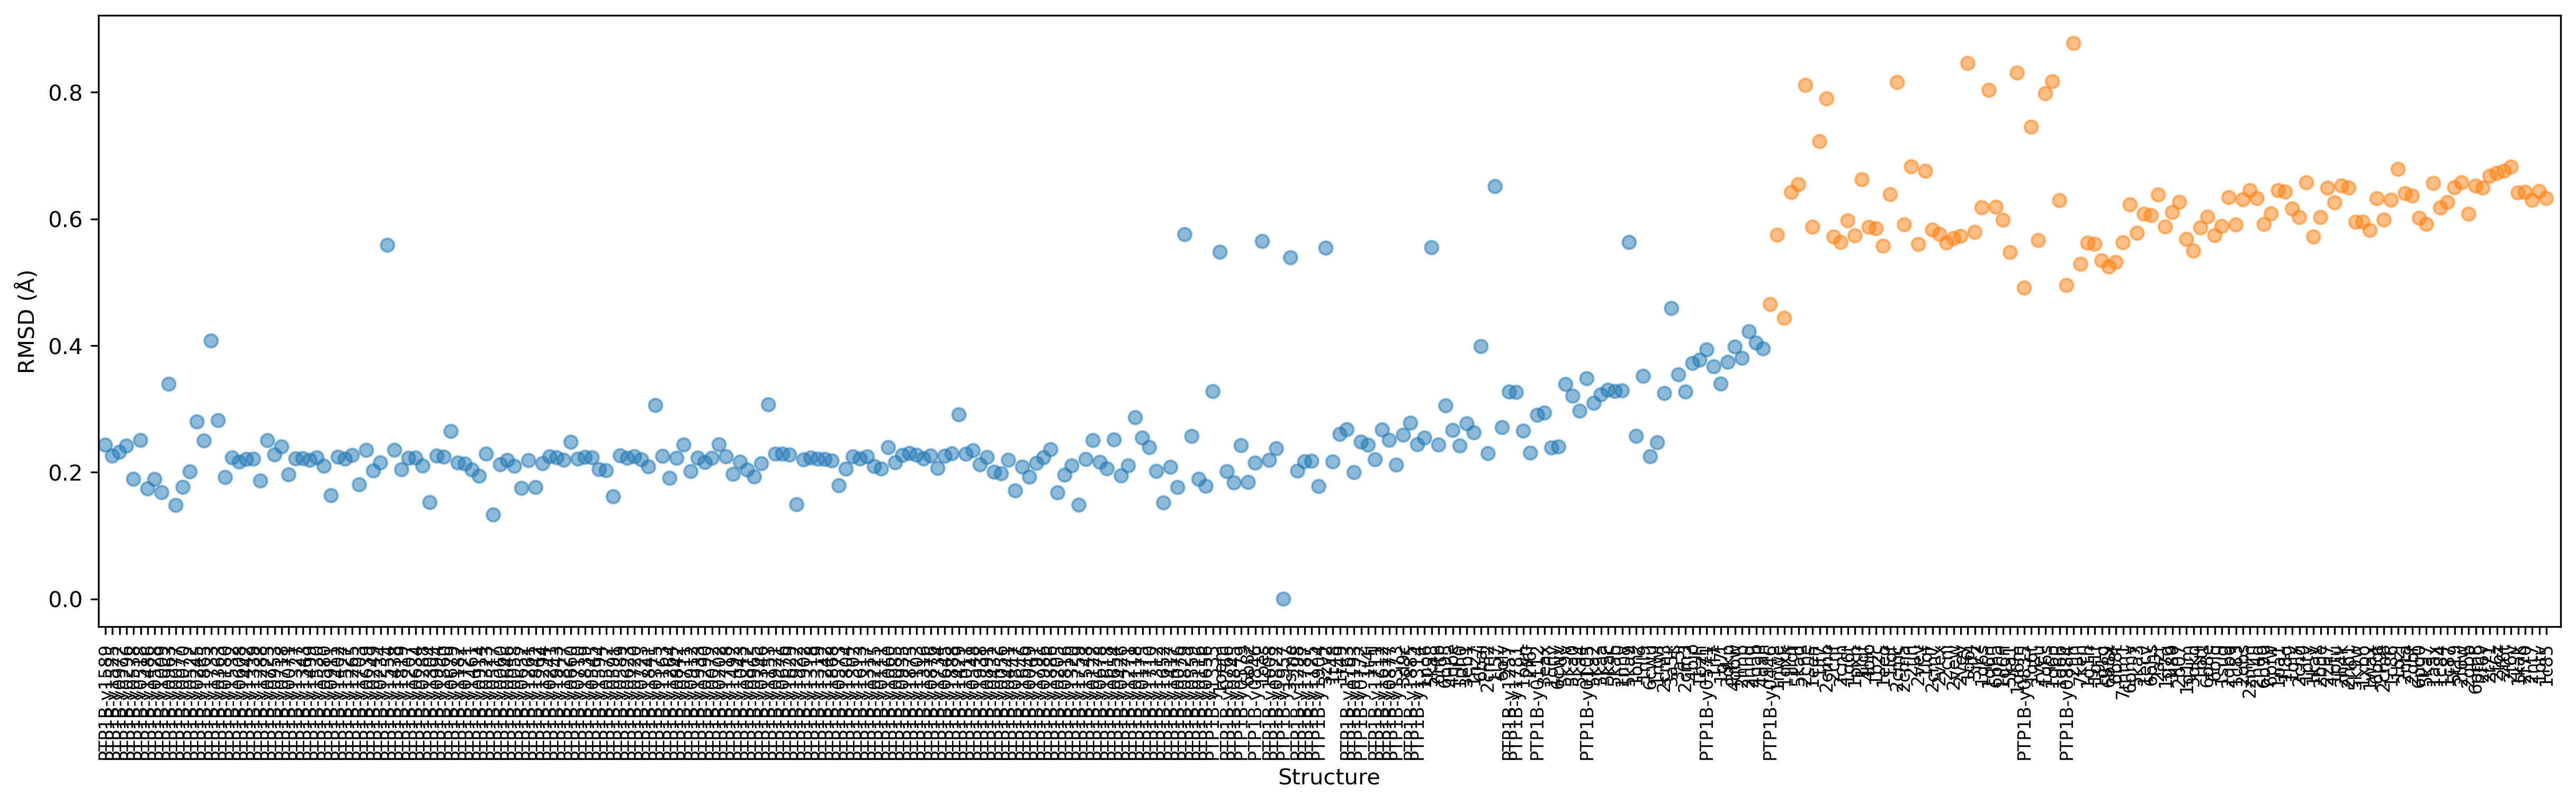

In [19]:
# allosteric steering for rope dihedrals pc 1 
fig, ax = plt.subplots(figsize=(20,5), dpi=300)

pc1_idxs = np.argsort(rope_A[:,0])
wpd_conformation = list()
ca_rmsds = list()
first = PandasPdb().read_pdb(f'../data/theseus_data/theseus_{rope_strucs[0]}.pdb')

first_coords = first.df['ATOM'].loc[(first.df['ATOM']['atom_name'] == 'CA') & 
                     (first.df['ATOM']['residue_number'] >= 7) & 
                     (first.df['ATOM']['residue_number'] <= 279)][['x_coord', 'y_coord', 'z_coord']].values
for i,struc in enumerate(rope_strucs[pc1_idxs]): 
    wpd_conformation.append(conformation_dict[struc].split('_')[0])
    current = PandasPdb().read_pdb(f'../data/theseus_data/theseus_{struc}.pdb')
    current_coords = current.df['ATOM'].loc[(current.df['ATOM']['atom_name'] == 'CA') & 
                                            (current.df['ATOM']['residue_number'] >= 7) & 
                                            (current.df['ATOM']['residue_number'] <= 279)][['x_coord', 'y_coord', 'z_coord']].values
    ca_rmsds.append(np.sqrt(np.mean(np.square(first_coords - current_coords))))
wpd_conformation = np.array(wpd_conformation)

ax.scatter(np.arange(rope_A.shape[0]), ca_rmsds, alpha=0.5, c=['tab:blue' if x == 'open' else 'tab:orange' for x in wpd_conformation])
ax.set_xlabel('Structure')
ax.set_ylabel('RMSD (Å)')
ax.set_xlim(left=-1, right=rope_A.shape[0]+1)
ax.set_xticks(np.arange(rope_A.shape[0]))
ax.set_xticklabels([x[:-7] for x in rope_strucs[pc1_idxs]], rotation='vertical', fontsize=8)
plt.show()

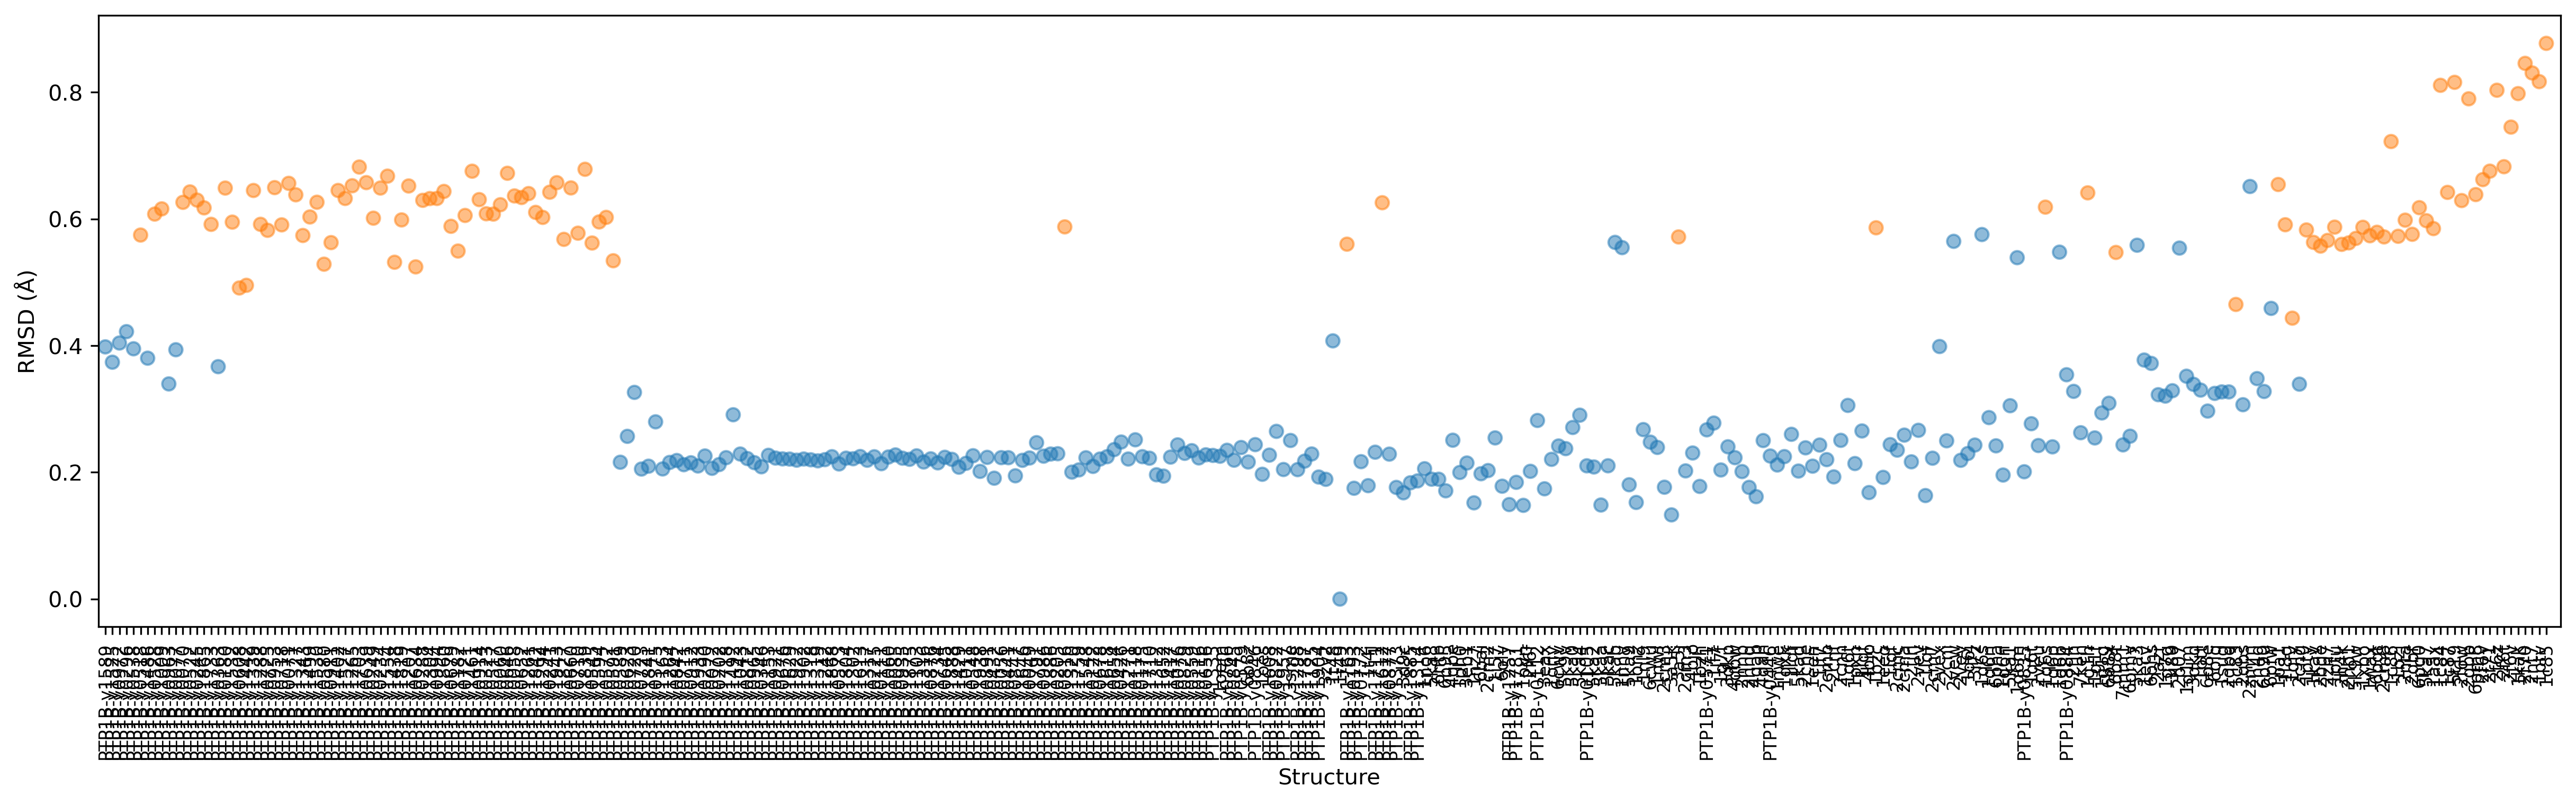

In [20]:
# allosteric steering for rope dihedrals pc 2
fig, ax = plt.subplots(figsize=(20,5), dpi=300)

pc2_idxs = np.argsort(rope_A[:,1])
wpd_conformation = list()
ca_rmsds = list()
first = PandasPdb().read_pdb(f'../data/theseus_data/theseus_{rope_strucs[0]}.pdb')

first_coords = first.df['ATOM'].loc[(first.df['ATOM']['atom_name'] == 'CA') & 
                     (first.df['ATOM']['residue_number'] >= 7) & 
                     (first.df['ATOM']['residue_number'] <= 279)][['x_coord', 'y_coord', 'z_coord']].values
for i,struc in enumerate(rope_strucs[pc2_idxs]): 
    wpd_conformation.append(conformation_dict[struc].split('_')[0])
    current = PandasPdb().read_pdb(f'../data/theseus_data/theseus_{struc}.pdb')
    current_coords = current.df['ATOM'].loc[(current.df['ATOM']['atom_name'] == 'CA') & 
                                            (current.df['ATOM']['residue_number'] >= 7) & 
                                            (current.df['ATOM']['residue_number'] <= 279)][['x_coord', 'y_coord', 'z_coord']].values
    ca_rmsds.append(np.sqrt(np.mean(np.square(first_coords - current_coords))))
wpd_conformation = np.array(wpd_conformation)

ax.scatter(np.arange(rope_A.shape[0]), ca_rmsds, alpha=0.5, c=['tab:blue' if x == 'open' else 'tab:orange' for x in wpd_conformation])
ax.set_xlabel('Structure')
ax.set_ylabel('RMSD (Å)')
ax.set_xlim(left=-1, right=rope_A.shape[0]+1)
ax.set_xticks(np.arange(rope_A.shape[0]))
ax.set_xticklabels([x[:-7] for x in rope_strucs[pc1_idxs]], rotation='vertical', fontsize=8)
plt.show()

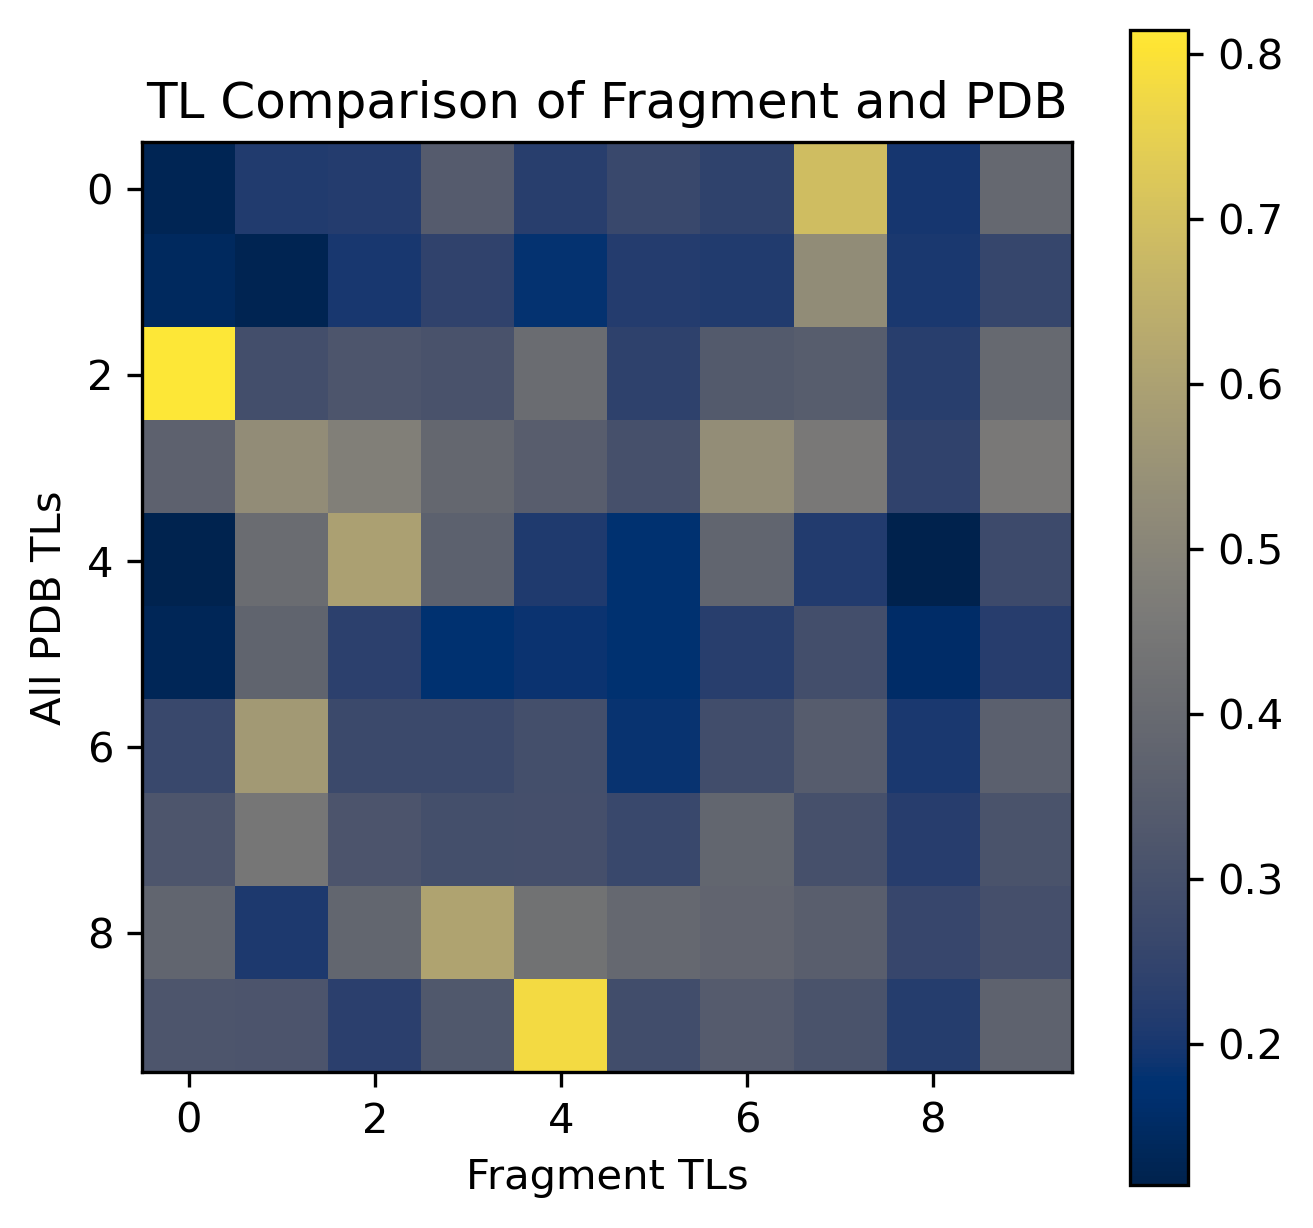

In [21]:
fig, ax = plt.subplots(figsize=(5,5),dpi=300)
dot_matrix = list()
for i in np.arange(10): 
    for j in np.arange(10): 

        dot_matrix.append(pearsonr(calculate_dihedral_transformed_loading(rope_pca.components_[i,:]), 
                                   calculate_dihedral_transformed_loading(fragment_pca.components_[j,:]))[0])

dot_matrix = np.array(dot_matrix).reshape(10,10)
im = ax.imshow(dot_matrix, cmap="cividis", interpolation="nearest")
ax.set_xlabel("Fragment TLs")
ax.set_ylabel("All PDB TLs")
ax.set_title(u"TL Comparison of Fragment and PDB")
plt.colorbar(im)
plt.show()

In [22]:
# calculate t-SNE and UMAP 
rope_tsne = TSNE(random_state = 0)
rope_umap = UMAP(n_neighbors = 50, random_state = 0)
rope_tsne_transform = rope_tsne.fit_transform(rope_dihedrals_data)
rope_umap_transform = rope_umap.fit_transform(rope_dihedrals_data)

/Users/asaeed/miniforge3/envs/comp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/asaeed/miniforge3/envs/comp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


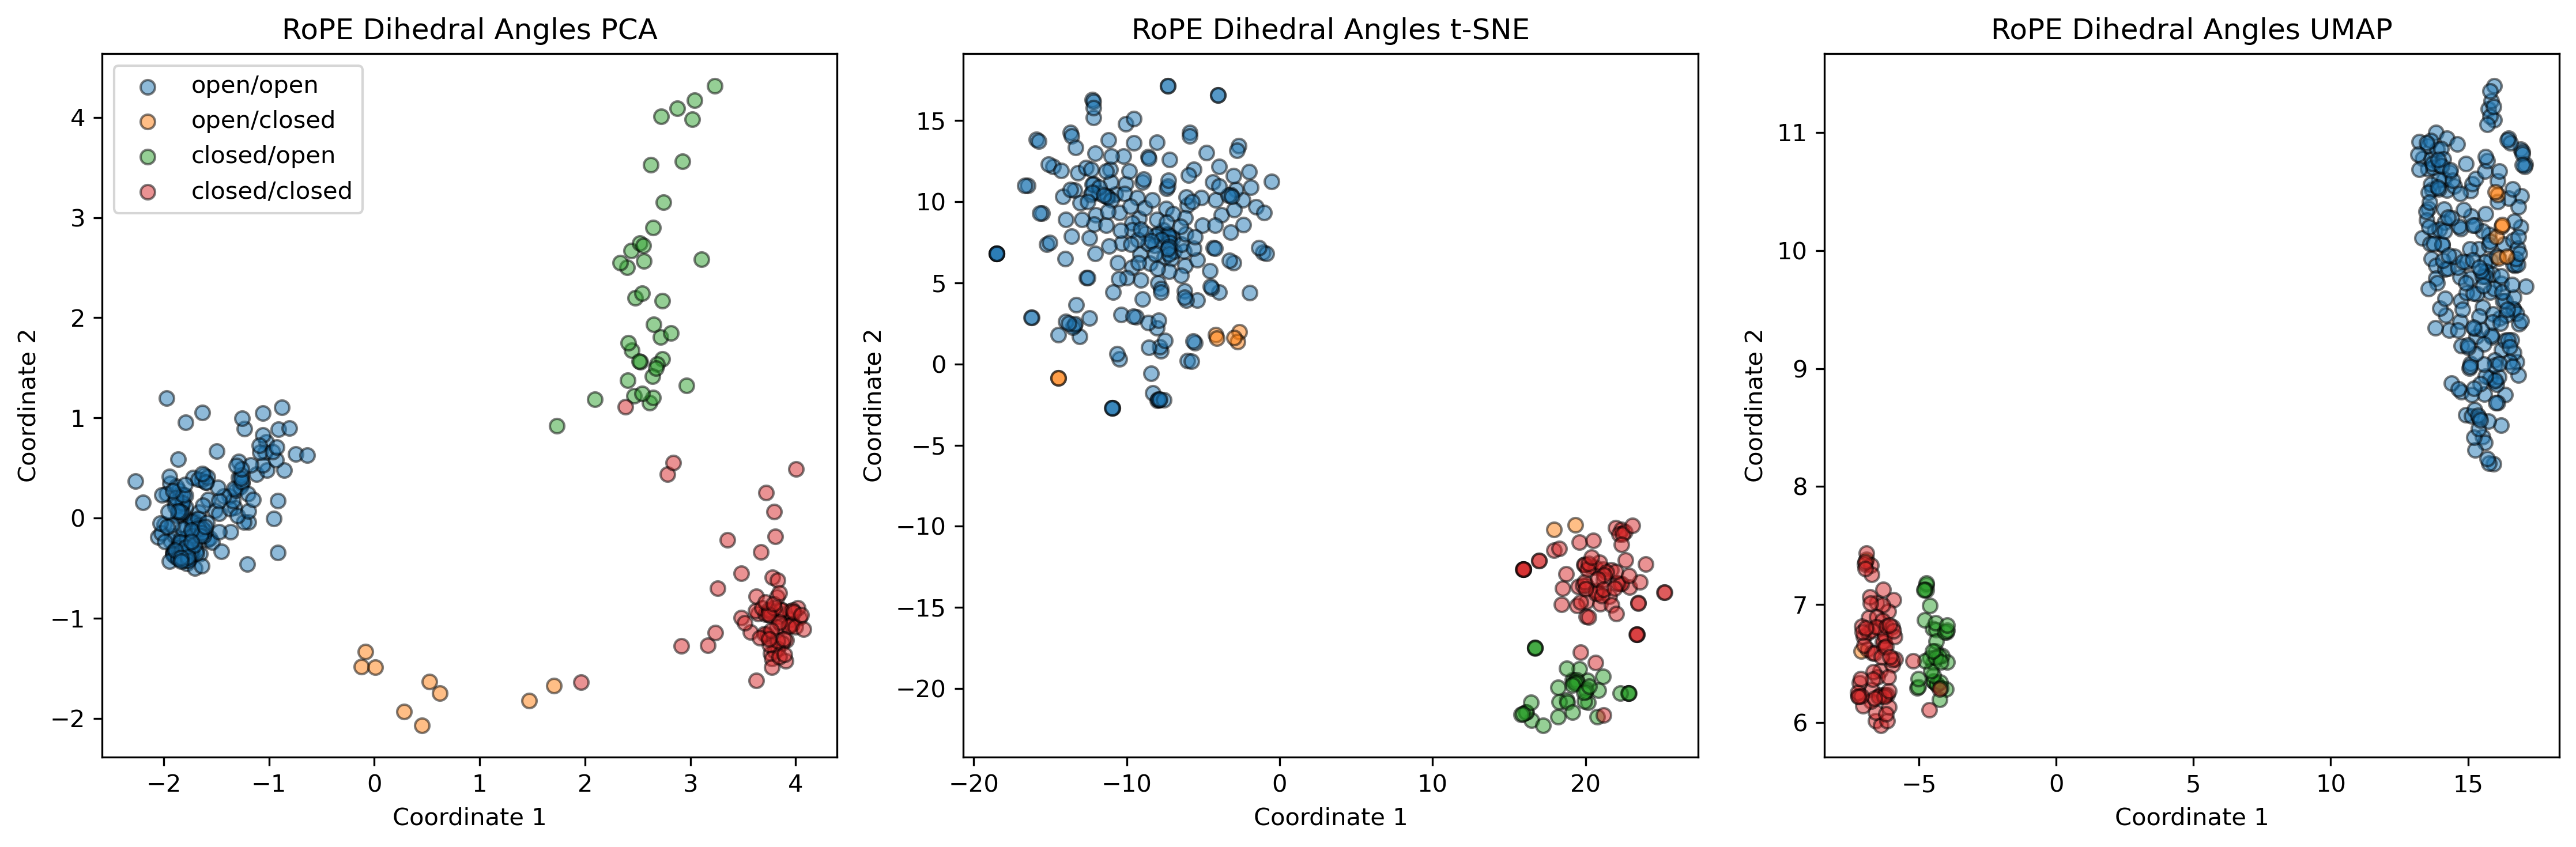

In [23]:
# plot PCA, t-SNE, and UMAP
fig, ax = plt.subplots(1, 3, figsize=(15,5), dpi=300); ax = ax.flatten()
transform_list = [
    rope_A, 
    rope_tsne_transform, 
    rope_umap_transform
]
struc_list_list = [
    rope_strucs,  
    rope_strucs, 
    rope_strucs
]
title_list = [
    "RoPE Dihedral Angles PCA", 
    "RoPE Dihedral Angles t-SNE", 
    "RoPE Dihedral Angles UMAP"
]

# enumerate the axes and the list of the PCAs
for i in np.arange(len(transform_list)): 

    # determine conformation color
    conformations = list()
    for k in struc_list_list[i]: 
        if k.startswith('../data'): 
            conformations.append(conformation_dict[k.split('/')[-1][8:-4]])
        else: 
            conformations.append(conformation_dict[k])

    conformations = np.array(conformations)
    cluster1 = ax[i].scatter(transform_list[i][conformations == "open_open",0], transform_list[i][conformations == "open_open",1], marker='o', alpha=0.5, edgecolor='k', linewidth=1, label="open/open")
    cluster2 = ax[i].scatter(transform_list[i][conformations == "open_closed",0], transform_list[i][conformations == "open_closed",1], marker='o', alpha=0.5, edgecolor='k', linewidth=1, label="open/closed")
    cluster3 = ax[i].scatter(transform_list[i][conformations == "closed_open",0], transform_list[i][conformations == "closed_open",1], marker='o', alpha=0.5, edgecolor='k', linewidth=1, label="closed/open")
    cluster4 = ax[i].scatter(transform_list[i][conformations == "closed_closed",0], transform_list[i][conformations == "closed_closed",1], marker='o', alpha=0.5, edgecolor='k', linewidth=1, label="closed/closed")
    ax[i].set_ylabel("Coordinate 2")
    ax[i].set_xlabel("Coordinate 1")
    ax[i].set_title(title_list[i])
ax[0].legend(loc="upper left", handles=[cluster1, cluster2, cluster3, cluster4], labels=["open/open", "open/closed", "closed/open", "closed/closed"])
plt.tight_layout()
plt.show()